In [ ]:
#@title
!pip install transformers datasets evaluate
!pip install eyecite
from transformers import pipeline
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
import torch.nn as nn
import torch
from transformers import AutoTokenizer
from transformers import DataCollatorWithPadding
import numpy as np
from datasets import load_dataset
import pandas as pd
import ipywidgets as widgets
from eyecite import find, clean
import re
from IPython.display import display, HTML, clear_output

# classifier_v1 = pipeline("text-classification", model="raminass/legal-bert-small-uncased", top_k=9, padding=True, truncation=True)
# classifier_v2 = pipeline("text-classification", model="raminass/scotus", top_k=9, padding=True, truncation=True)
# classifier_v3 = pipeline("text-classification", model="raminass/scotus_10", top_k=9, padding=True, truncation=True)
# classifier_v4 = pipeline("text-classification", model="raminass/scotus_15", top_k=9, padding=True, truncation=True)
# # loading Data and Model
classifier_v8 = pipeline("text-classification", model="raminass/scotus_new", top_k=13, padding=True, truncation=True)
# https://discuss.huggingface.co/t/idtolabel-argument-in-text-classification-pipeline/24331/2
classifier_v8.model.config.id2label = {0: 'Justice Breyer',
 1: 'Justice Ginsburg',
 2: 'Justice Alito',
 3: "Justice Sotomayor",
 4: 'Justice Roberts',
 5: 'Justice Kennedy',
 6: "Justice O'Connor",
 7: 'Justice Rehnquist',
 8: 'Justice Scalia',
 9: 'Justice Souter',
 10: 'Justice Stevens',
 11: 'Justice Thomas',
 12: 'Justice Kagan'}

classifier_v10 = pipeline("text-classification", model="raminass/scotus-v10", top_k=13, padding=True, truncation=True)

all = load_dataset('raminass/opinions_1994_2020')
# all = load_dataset('raminass/opinions_1994_2005')
df_train = pd.DataFrame(all['train'])
df_train['clean_text'] = df_train['text']
# filter short chuncks
df_train = df_train[df_train['clean_text'].str.len()>1000]
cases = list(df_train[df_train.category=='per_curiam'].case_name.unique())
cases.sort()

In [4]:
#@title

def full_case(citation, text):
    text = text.replace(citation.matched_text(), "")
    if citation.metadata.year:
      pattern = r'\([^)]*{}\)'.format(citation.metadata.year)  # Matches any word that ends with "year"
      text = re.sub(pattern, '', text)
    if citation.metadata.pin_cite:
      text = text.replace(citation.metadata.pin_cite, "")
    if citation.metadata.parenthetical:
      text = text.replace(f"({citation.metadata.parenthetical})", "")
    if citation.metadata.plaintiff:
      text = text.replace(f"{citation.metadata.plaintiff} v. {citation.metadata.defendant}", "")
    publisher_date = " ".join(i for i in (citation.metadata.court, citation.metadata.year) if i)
    if publisher_date:
      text = text.replace(f"{publisher_date}", "")
    if citation.metadata.extra:
      text = text.replace(citation.metadata.extra, "")
    return text

def supra_case(citation, text):
    text = text.replace(citation.matched_text(), "")
    if citation.metadata.pin_cite:
      text = text.replace(citation.metadata.pin_cite, "")
    if citation.metadata.parenthetical:
      text = text.replace(f"({citation.metadata.parenthetical})", "")
    if citation.metadata.antecedent_guess:
      text = text.replace(citation.metadata.antecedent_guess, "")
    return text

def short_case(citation, text):
    text = text.replace(citation.matched_text(), "")
    if citation.metadata.parenthetical:
      text = text.replace(f"({citation.metadata.parenthetical})", "")
    if citation.metadata.year:
      pattern = r'\([^)]*{}\)'.format(citation.metadata.year)
    if citation.metadata.antecedent_guess:
      text = text.replace(citation.metadata.antecedent_guess, "")
    return text

def id_case(citation, text):
    text = text.replace(citation.matched_text(), "")
    if citation.metadata.parenthetical:
      text = text.replace(f"({citation.metadata.parenthetical})", "")
    if citation.metadata.pin_cite:
      text = text.replace(citation.metadata.pin_cite, "")
    return text

def unknown_case(citation, text):
    text = text.replace(citation.matched_text(), "")
    if citation.metadata.parenthetical:
      text = text.replace(f"({citation.metadata.parenthetical})", "")
    return text

def full_law_case(citation, text):
    text = text.replace(citation.matched_text(), "")
    if citation.metadata.parenthetical:
      text = text.replace(f"({citation.metadata.parenthetical})", "")
    return text

def full_journal_case(citation, text):
    text = text.replace(citation.matched_text(), "")
    if citation.metadata.year:
      pattern = r'\([^)]*{}\)'.format(citation.metadata.year)  # Matches any word that ends with "year"
      text = re.sub(pattern, '', text)
    if citation.metadata.pin_cite:
      text = text.replace(citation.metadata.pin_cite, "")
    if citation.metadata.parenthetical:
      text = text.replace(f"({citation.metadata.parenthetical})", "")
    return text

def all_commas(text: str) -> str:
    return re.sub(r"\,+", ",", text)

def all_dots(text: str) -> str:
    return re.sub(r"\.+", ".", text)

functions_dict = {
    'FullCaseCitation': full_case,
    'SupraCitation': supra_case,
    'ShortCaseCitation': short_case,
    'IdCitation': id_case,
    'UnknownCitation': unknown_case,
    'FullLawCitation': full_law_case,
    'FullJournalCitation': full_journal_case,
}

def remove_citations(input_text):
  #clean text
  plain_text = clean.clean_text(input_text, ['html', 'inline_whitespace', 'underscores'])
  #remove citations
  found_citations = find.get_citations(plain_text)
  for citation in found_citations:
    plain_text = functions_dict[citation.__class__.__name__](citation, plain_text)
  #clean text
  plain_text = clean.clean_text(plain_text, ['inline_whitespace', 'underscores','all_whitespace', all_commas, all_dots])
  plain_text = clean.clean_text(plain_text, ['inline_whitespace','all_whitespace'])
  pattern = r"\*?\d*\s*I+\n"
  plain_text = re.sub(pattern, '', plain_text)
  pattern = r"\s[,.]"
  plain_text = re.sub(pattern, '', plain_text)
  return plain_text

def split_text(text):
    words = text.split()
    chunks = []
    for i in range(0, len(words), 420):
        chunks.append(' '.join(words[i:i+430]))
    return chunks

def split_data(data):

  data_dict = {'text': []}
  opinions_split = pd.DataFrame(data_dict)
  chunks = split_text(data)
  for chunk in chunks:
    if len(chunk)<1000:
      continue
    tmp = pd.DataFrame({'label': [200],'text': [chunk]})
    opinions_split = pd.concat([opinions_split, tmp])
  return opinions_split

def predict_judge(case, classifier):
  # result = classifier(df_train[(df_train.case_name==case) & (df_train.category=='per_curiam')]['clean_text'].to_list())
  result = eval(model+f"""(df_train[(df_train.case_name=='{case}') & (df_train.category=='per_curiam')]['clean_text'].to_list())""")
  pred = {}
  for i in result:
    key= i[0]['label']
    if key not in pred:
      pred[key] = 1/len(result)
    else:
      pred[key] +=1/len(result)
  return dict(sorted(pred.items(), key=lambda x: x[1],reverse=True))

def max_judge(case, classifier):
  # result = classifier(df_train[(df_train.case_name==case) & (df_train.category=='per_curiam')]['clean_text'].to_list())
  result = eval(model+f"""(df_train[(df_train.case_name=='{case}') & (df_train.category=='per_curiam')]['clean_text'].to_list())""")
  pred = {}
  for i in result:
    key= i[0]['label']
    if key not in pred:
      pred[key] = i[0]['score']
    else:
      if i[0]['score'] > pred[key]:
        pred[key] = i[0]['score']
  total = sum(np.exp(list(pred.values())))
  res = {k:np.exp(v)/total for k,v in pred.items()}
  return dict(sorted(res.items(), key=lambda x: x[1],reverse=True))

def softmax(case, model):
  # result = classifier(df_train[(df_train.case_name==case) & (df_train.category=='per_curiam')]['clean_text'].to_list())
  result = eval(model+f"""(df_train[(df_train.case_name=='{case}') & (df_train.category=='per_curiam')]['clean_text'].to_list())""")
  pred = {}
  for c in result:
    for d in c:
      if d['label'] not in pred:
        pred[d['label']] = [d['score']]
      else:
        pred[d['label']].append(d['score'])
  sumary = {k:sum(v) for k,v in pred.items()}
  total = sum(np.exp(list(sumary.values())))
  res = {k:np.exp(v)/total for k,v in sumary.items()}
  return dict(sorted(res.items(), key=lambda x: x[1],reverse=True)), result

def average(case, model):
  # result = classifier(df_train[(df_train.case_name==case) & (df_train.category=='per_curiam')]['clean_text'].to_list())
  result = eval(model+f"""(df_train[(df_train.case_name=='{case}') & (df_train.category=='per_curiam')]['clean_text'].to_list())""")
  pred = {}
  for c in result:
    for d in c:
      if d['label'] not in pred:
        pred[d['label']] = [round(d['score'],2)]
      else:
        pred[d['label']].append(round(d['score'],2))
  sumary = {k:round(sum(v)/len(v),2) for k,v in pred.items()}
  result = [[{k: round(v, 2) if k=='score' else v for k, v in dct.items()} for dct in lst ]  for lst in result]
  return dict(sorted(sumary.items(), key=lambda x: x[1],reverse=True)), result

def average_text(text, model):
  # result = classifier(df_train[(df_train.case_name==case) & (df_train.category=='per_curiam')]['clean_text'].to_list())
  result = eval(model+f"""({text})""")
  pred = {}
  for c in result:
    for d in c:
      if d['label'] not in pred:
        pred[d['label']] = [round(d['score'],2)]
      else:
        pred[d['label']].append(round(d['score'],2))
  sumary = {k:round(sum(v)/len(v),2) for k,v in pred.items()}
  result = [[{k: round(v, 2) if k=='score' else v for k, v in dct.items()} for dct in lst ]  for lst in result]
  return dict(sorted(sumary.items(), key=lambda x: x[1],reverse=True)), result
  #############

case_picker = widgets.Dropdown(options=cases, description='Case Name:')
output = widgets.Output()
display(case_picker, output)

Dropdown(description='Case Name:', options=('Adams v. Robertson', 'Adarand Constructors, Inc. v. Mineta', 'Ada…

Output()

In [ ]:
#@title
result = average(case_picker.value, 'classifier_v10')
display(HTML(df_train[df_train.case_name==case_picker.value].iloc[:1,:-2].head().to_html(render_links=True, escape=False)))
print(f"average prediction:")
display(result[0])
print(f"paragraph prediction:")
display(result[1])

# Free Text

In [7]:
print(opinion)

As this Court explained in Obergefell v. Hodges, 576 U. S. ___ (2015), the Constitution entitles same-sex couples to civil marriage “on the same terms and conditions as opposite-sex couples.” Id., at ___ (slip op., at 23). In the decision below, the Arkansas Supreme Court considered the effect of that holding on the State’s rules governing the issuance of birth certificates. When a married woman gives birth in Arkansas, state law generally requires the name of the mother’s male spouse to appear on the child’s birth certificate—regardless of his biological relationship to the child. According to the court below, however, Arkansas need not extend that rule to similarly situated same-sex couples: The State need not, in other words, issue birth certificates including the female spouses of women who give birth in the State. Because that differential treatment infringes Obergefell’s commitment to provide same-sex couples “the constellation of benefits that the States have linked to marriage,

In [6]:
opinion = "As this Court explained in Obergefell v. Hodges, 576 U. S. ___ (2015), the Constitution entitles same-sex couples to civil marriage \u201Con the same terms and conditions as opposite-sex couples.\u201D Id., at ___ (slip op., at 23). In the decision below, the Arkansas Supreme Court considered the effect of that holding on the State\u2019s rules governing the issuance of birth certificates. When a married woman gives birth in Arkansas, state law generally requires the name of the mother\u2019s male spouse to appear on the child\u2019s birth certificate\u2014regardless of his biological relationship to the child. According to the court below, however, Arkansas need not extend that rule to similarly situated same-sex couples: The State need not, in other words, issue birth certificates including the female spouses of women who give birth in the State. Because that differential treatment infringes Obergefell\u2019s commitment to provide same-sex couples \u201Cthe constellation of benefits that the States have linked to marriage,\u201D id., at ___ (slip op., at 17), we reverse the state court\u2019s judgment.  The petitioners here are two married same-sex couples who conceived children through anonymous sperm donation. Leigh and Jana Jacobs were married in Iowa in 2010, and Terrah and Marisa Pavan were married in New Hampshire in 2011. Leigh and Terrah each gave birth to a child in Arkansas in 2015. When it came time to secure birth certificates for the newborns, each couple filled out paperwork listing both spouses as parents\u2014Leigh and Jana in one case, Terrah and Marisa in the other. Both times, however, the Arkansas Department of Health issued certificates bearing only the birth mother\u2019s name.  The department\u2019s decision rested on a provision of Arkansas law, Ark. Code \xA720\u201318\u2013401 (2014), that specifies which individuals will appear as parents on a child\u2019s state-issued birth certificate. \u201CFor the purposes of birth registration,\u201D that statute says, \u201Cthe mother is deemed to be the woman who gives birth to the child.\u201D \xA720\u201318\u2013401(e). And \u201C[i]f the mother was married at the time of either conception or birth,\u201D the statute instructs that \u201Cthe name of [her] husband shall be entered on the certificate as the father of the child.\u201D \xA720\u201318\u2013401(f)(1). There are some limited exceptions to the latter rule\u2014for example, another man may appear on the birth certificate if the \u201Cmother\u201D and \u201Chusband\u201D and \u201Cputative father\u201D all file affidavits vouching for the putative father\u2019s paternity. Ibid. But as all parties agree, the requirement that a married woman\u2019s husband appear on her child\u2019s birth certificate applies in cases where the couple conceived by means of artificial insemination with the help of an anonymous sperm donor. See Pet. for Cert. 4; Brief in Opposition 3\u20134; see also Ark.Code \xA79\u201310\u2013201(a) (2015) (\u201CAny child born to a married woman by means of artificial insemination shall be deemed the legitimate natural child of the woman and the woman\u2019s husband if the husband consents in writing to the artificial insemination\u201D).  The Jacobses and Pavans brought this suit in Arkansas state court against the director of the Arkansas Department of Health\u2014seeking, among other things, a declaration that the State\u2019s birth-certificate law violates the Constitution. The trial court agreed, holding that the relevant portions of \xA720\u201318\u2013401 are inconsistent with Obergefell because they \u201Ccategorically prohibi[t] every same-sex married couple . . . from enjoying the same spousal benefits which are available to every opposite-sex married couple.\u201D App. to Pet. for Cert. 59a. But a divided Arkansas Supreme Court reversed that judgment, concluding that the statute \u201Cpass[es] constitutional muster.\u201D 2016 Ark. 437, 505 S. W. 3d 169, 177. In that court\u2019s view, \u201Cthe statute centers on the relationship of the biological mother and the biological father to the child, not on the marital relationship of husband and wife,\u201D and so it \u201Cdoes not run afoul of Obergefell.\u201D Id., at 178. Two justices dissented from that view, maintaining that under Obergefell \u201Ca same-sex married couple is entitled to a birth certificate on the same basis as an opposite-sex marriedcouple.\u201D 505 S. W. 3d, at 184 (Brill, C. J., concurring in part and dissenting in part); accord, id., at 190 (Danielson, J., dissenting).  The Arkansas Supreme Court\u2019s decision, we conclude, denied married same-sex couples access to the \u201Cconstellation of benefits that the Stat[e] ha[s] linked to marriage.\u201D Obergefell, 576 U. S., at ___ (slip op., at 17). As already explained, when a married woman in Arkansas conceives a child by means of artificial insemination, the State will\u2014indeed, must\u2014list the name of her male spouse on the child\u2019s birth certificate. See \xA720\u201318\u2013401(f )(1); see also \xA79\u201310\u2013201; supra, at 2. And yet state law, as interpreted by the court below, allows Arkansas officials in those very same circumstances to omit a married woman\u2019s female spouse from her child\u2019s birth certificate. See 505 S. W. 3d, at 177\u2013178. As a result, same-sex parents in Arkansas lack the same right as opposite-sex parents to be listed on a child\u2019s birth certificate, a document often used for important transactions like making medical decisions for a child or enrolling a child in school. See Pet. for Cert. 5\u20137 (listing situations in which a parent might be required to present a child\u2019s birth certificate).  Obergefell proscribes such disparate treatment. As we explained there, a State may not \u201Cexclude same-sexcouples from civil marriage on the same terms and conditions as opposite-sex couples.\u201D 576 U. S., at ___ (slip op., at 23). Indeed, in listing those terms and conditions\u2014the \u201Crights, benefits, and responsibilities\u201D to which same-sex couples, no less than opposite-sex couples, must have access\u2014we expressly identified \u201Cbirth and death certificates.\u201D Id., at ___ (slip op., at 17). That was no accident: Several of the plaintiffs in Obergefell challenged a State\u2019s refusal to recognize their same-sex spouses on their children\u2019s birth certificates. See DeBoer v. Snyder, 772 F. 3d 388, 398\u2013399 (CA6 2014). In considering those challenges, we held the relevant state laws unconstitutional to the extent they treated same-sex couples differently from opposite-sex couples. See 576 U. S., at ___ (slip op., at 23). That holding applies with equal force to \xA720\u201318\u2013401.  Echoing the court below, the State defends its birth-certificate law on the ground that being named on a child\u2019s birth certificate is not a benefit that attends marriage. Instead, the State insists, a birth certificate is simply a device for recording biological parentage\u2014regardless of whether the child\u2019s parents are married. But Arkansas law makes birth certificates about more than just genetics. As already discussed, when an opposite-sex couple conceives a child by way of anonymous sperm donation\u2014just as the petitioners did here\u2014state law requires the placement of the birth mother\u2019s husband on the child\u2019s birth certificate. See supra, at 2. And that is so even though (as the State concedes) the husband \u201Cis definitively not the biological father\u201D in those circumstances. Brief in Opposition 4.[1]* Arkansas has thus chosen to make its birth certificates more than a mere marker of biological relationships: The State uses those certificates to give married parents a form of legal recognition that is not available to unmarried parents. Having made that choice, Arkansas may not, consistent with Obergefell, deny married same-sex couples that recognition.  The petition for a writ of certiorari and the pending motions for leave to file briefs as amici curiae are granted. The judgment of the Arkansas Supreme Court is reversed, and the case is remanded for further proceedings not inconsistent with this opinion.  It is so ordered." #@param {type:"string"}

result = average_text(split_data(remove_citations(opinion))['text'].to_list(),'classifier_v10')
print(f"average prediction:")
display(result[0])
print(f"paragraph prediction:")
display(result[1])

average prediction:


{'Justice Alito': 0.53,
 'Justice Kagan': 0.22,
 'Justice Scalia': 0.12,
 'Justice Ginsburg': 0.06,
 'Justice Breyer': 0.04,
 'Justice Kennedy': 0.01,
 'Justice Roberts': 0.01,
 'Justice Thomas': 0.0,
 'Justice Rehnquist': 0.0,
 'Justice Sotomayor': 0.0,
 'Justice Souter': 0.0,
 'Justice Stevens': 0.0,
 "Justice O'Connor": 0.0}

paragraph prediction:


[[{'label': 'Justice Alito', 'score': 0.99},
  {'label': 'Justice Kennedy', 'score': 0.01},
  {'label': 'Justice Thomas', 'score': 0.0},
  {'label': 'Justice Scalia', 'score': 0.0},
  {'label': 'Justice Breyer', 'score': 0.0},
  {'label': 'Justice Roberts', 'score': 0.0},
  {'label': 'Justice Rehnquist', 'score': 0.0},
  {'label': 'Justice Sotomayor', 'score': 0.0},
  {'label': 'Justice Souter', 'score': 0.0},
  {'label': 'Justice Ginsburg', 'score': 0.0},
  {'label': 'Justice Kagan', 'score': 0.0},
  {'label': 'Justice Stevens', 'score': 0.0},
  {'label': "Justice O'Connor", 'score': 0.0}],
 [{'label': 'Justice Alito', 'score': 0.6},
  {'label': 'Justice Ginsburg', 'score': 0.18},
  {'label': 'Justice Breyer', 'score': 0.13},
  {'label': 'Justice Kagan', 'score': 0.04},
  {'label': 'Justice Roberts', 'score': 0.04},
  {'label': 'Justice Kennedy', 'score': 0.01},
  {'label': 'Justice Stevens', 'score': 0.0},
  {'label': 'Justice Souter', 'score': 0.0},
  {'label': 'Justice Rehnquist', 

# Predict All

In [ ]:
def average_bulk(case, category, model):
  # result = classifier(df_train[(df_train.case_name==case) & (df_train.category=='per_curiam')]['clean_text'].to_list())
  result = eval(model+f"""(df_train[(df_train.case_name=="{case}") & (df_train.category=='{category}')]['clean_text'].to_list())""")
  pred = {}
  for c in result:
    for d in c:
      if d['label'] not in pred:
        pred[d['label']] = [round(d['score'],2)]
      else:
        pred[d['label']].append(round(d['score'],2))
  sumary = {k:round(sum(v)/len(v),2) for k,v in pred.items()}
  result = [[{k: round(v, 2) if k=='score' else v for k, v in dct.items()} for dct in lst ]  for lst in result]
  sorted_dict = dict(sorted(sumary.items(), key=lambda x: x[1],reverse=True))
  final = ''
  for x in list(sorted_dict)[0:3]:
    final+=f"""{x}:{sorted_dict[x]}, """
  return final

In [ ]:
average_bulk("McCutcheon v. Federal Election Comm'n", 'majority', 'classifier_v8')

"Justice Roberts:1.0, Justice Kagan:0.0, Justice O'Connor:0.0, "

In [ ]:
new_df = df_train[['author_name','category', 'case_name','url']].drop_duplicates()

In [ ]:
new_df['model_prediction'] = new_df.apply(lambda x: average_bulk(x['case_name'], x['category'], 'classifier_v10'), axis=1)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
new_df.to_csv('/content/drive/MyDrive/research/projects/supreme_court/all_prediction_v10.csv')

# Sanity

In [ ]:
for model in ['classifier_v2', 'classifier_v3', 'classifier_v4']:
  data_dict = {'case_name': [], 'url':[], 'predcition':[], 'dissenting':[], 'concurring':[]}
  model_sanity = pd.DataFrame(data_dict)
  for case in cases:
    result = average(case, model)
    concurring = ", ".join(list(df_train[(df_train.case_name==case) & (df_train.category=='concurring')]['author_name'].unique()))
    dissenting = ", ".join(list(df_train[(df_train.case_name==case) & (~df_train.category.isin(['per_curiam','concurring']))]['author_name'].unique()))
    url = df_train[df_train.case_name==case]['url'].iloc[0]
    tmp = pd.DataFrame({'case_name': [case],'predcition': [result[0]], 'url':[url],
                        'dissenting':[dissenting], 'concurring':[concurring]})
    model_sanity = pd.concat([model_sanity, tmp])

  model_sanity.to_csv(f"/content/drive/MyDrive/research/projects/supreme_court/model_sanity_{model}.csv", index = False)

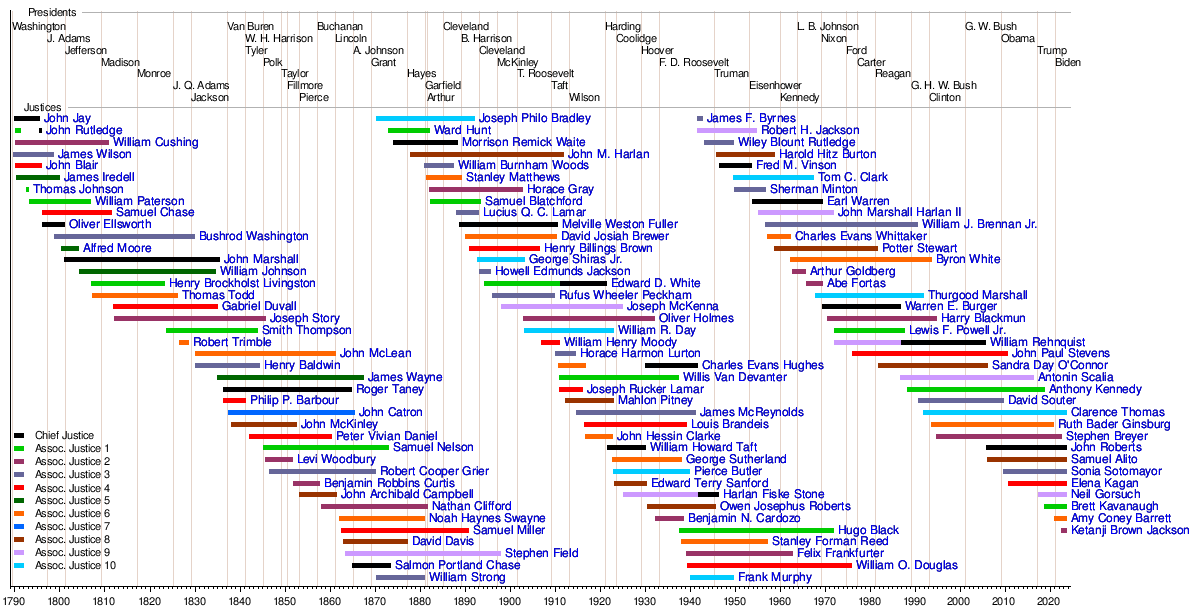